In [1]:
import sys

sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/')

# Standard libraries
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# Data
from src.data.classification import load_esdc

# Feature Extraction/Transformations
from src.features.classification import add_drought_mask, extract_df, subset_time, extract_region
from src.features.stats import calculate_classification_stats
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from esdc.shape import rasterize
import geopandas as gpd

# SVM Model and Derivative functions
from src.models.classification import svm_naive, predict_batches
from src.models.derivatives import SVMDerivative

# Visualization
from src.visualization.utils import create_grid
from esdc.visualize import plot_xarray_on_map, plot_map
from src.visualization.classification import plot_toy_data, plot_predictions, plot_sensitivity
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
xr.set_options(display_style='html')
plt.style.use(['seaborn-talk'])

# notebook extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
figures_path = '/home/emmanuel/projects/2019_sakame/reports/figures/sampling/'
data_xr_path = '/home/emmanuel/projects/2019_sakame/data/results/sampling/'

variables = [

#     'land_surface_temperature',
#     'gross_primary_productivity',
#     'air_temperature_2m',
#     'precipitation',
#     'evaporation',
#     'soil_moisture',
#     'surface_moisture',
]
window_sizes = [2, 3, 4, 5, 6, 7] #, 8, 9 , 10]
variable = 'gross_primary_productivity'

In [3]:
with xr.open_dataset(data_xr_path + f"sampling_{variable}.nc") as xr_data:
    pass

xr_data

<xarray.Dataset>
Dimensions:      (lat: 144, lon: 312, time: 11, window: 9)
Coordinates:
  * lon          (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat          (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
    mask         (lat, lon) float32 ...
  * time         (time) datetime64[ns] 2010-01-05 2010-01-05 ... 2010-01-05
  * window       (window) int64 2 3 4 5 6 7 8 9 10
Data variables:
    labels       (lat, lon, time, window) float64 ...
    sensitivity  (lat, lon, time, window) float64 ...
    predictions  (lat, lon, time, window) float64 ...

In [19]:
vmin = xr_data.sensitivity.min()
vmax = xr_data.sensitivity.max()
print(vmax)

<xarray.DataArray 'sensitivity' ()>
array(8.06989986)


In [4]:
# colormaps
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
cmap = 'Reds'

## Gross Primary Productivity

In [19]:
min_sens = xr_data.sensitivity.min()
max_sens = xr_data.sensitivity.max()
import matplotlib

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(array([2.1000e+01, 2.6000e+01, 1.0900e+02, 2.1380e+03, 1.3141e+04,
        1.1388e+04, 1.1110e+03, 1.1300e+02, 3.2000e+01, 6.0000e+00]),
 array([-0.09410504, -0.03800567,  0.0180937 ,  0.07419306,  0.13029243,
         0.1863918 ,  0.24249117,  0.29859054,  0.3546899 ,  0.41078927,
         0.46688864]),
 <a list of 10 Patch objects>)

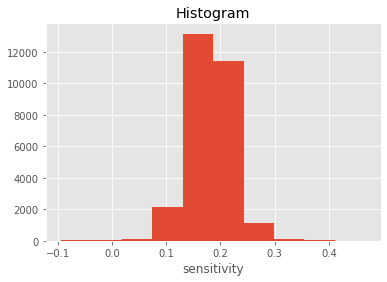

In [24]:
xr_data.sensitivity.sel(window=3).mean(dim='time', skipna=True).where(xr_data.mask == 1).plot.hist()

In [17]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = matplotlib.cm.Reds
norm = matplotlib.colors.LogNorm(vmin=min_sens, vmax=max_sens)

cb = matplotlib.colorbar.ColorbarBase(
    ax, 
    cmap=cmap,   # Colormap
    norm=norm,
    orientation='horizontal'
)
# cb.ax.set_xticklabels(["Non-Drought", "Drought"], weight='bold', fontsize=20)
# cb.set_label('Sensitivity', fontsize=20, weight='bold')
cb.ax.tick_params(axis='both', which='major', labelsize=20)


save_name = "ee_svm_sens_cb.png"
# fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=200, bbox_inches = "tight")
plt.show()

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


ValueError: math domain error

WINDOW: 2x2


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


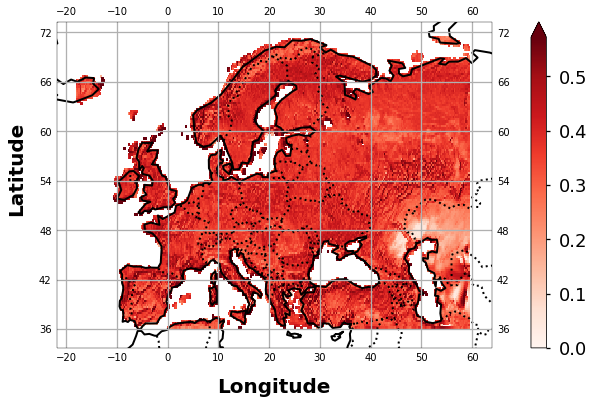

WINDOW: 3x3


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


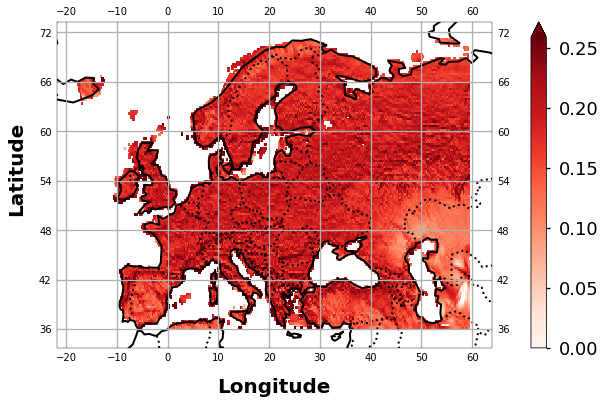

WINDOW: 4x4


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


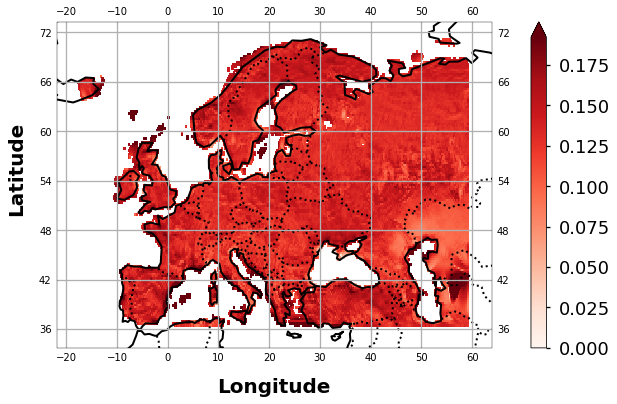

WINDOW: 5x5


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


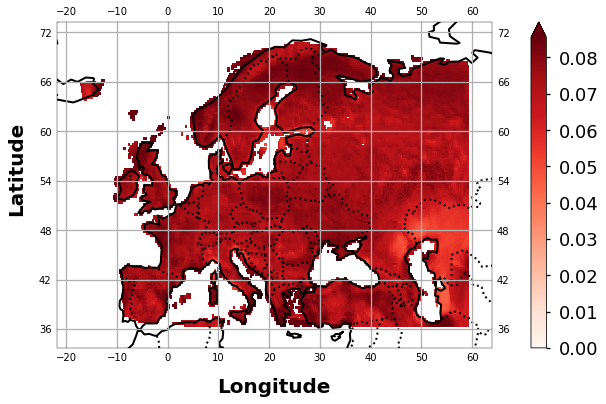

WINDOW: 6x6


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


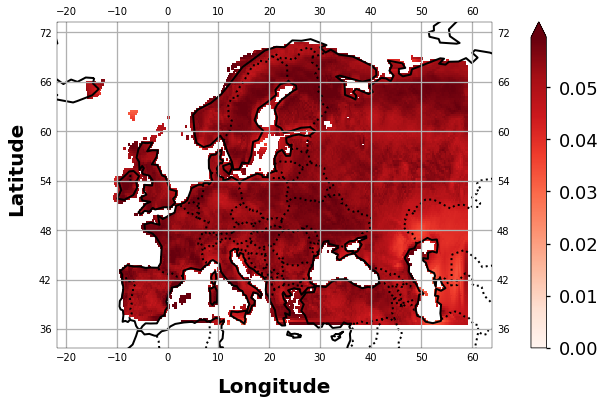

WINDOW: 7x7


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


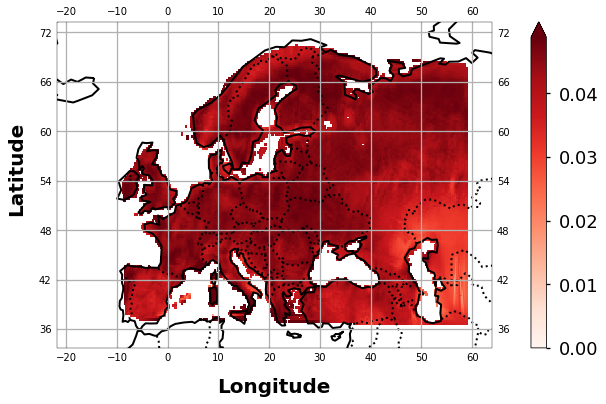

WINDOW: 8x8


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


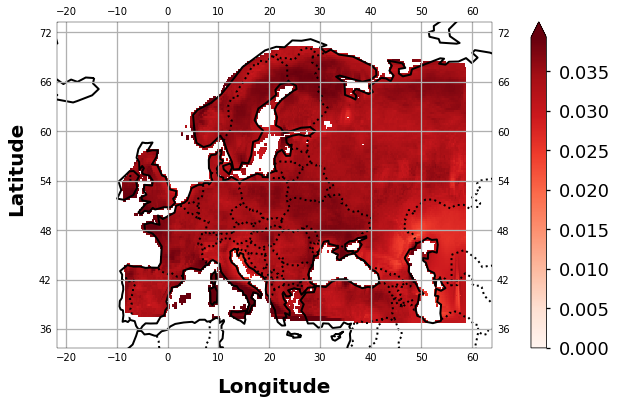

WINDOW: 9x9


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


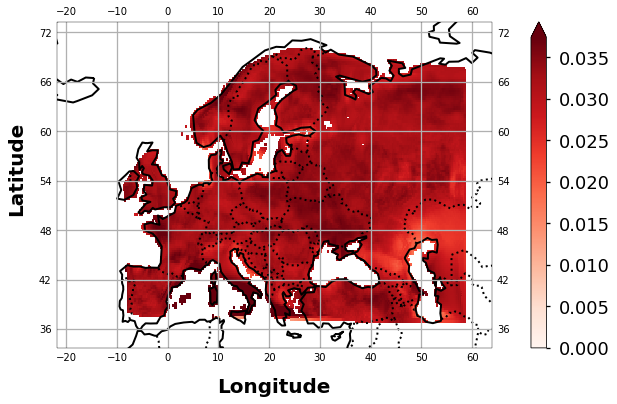

WINDOW: 10x10


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


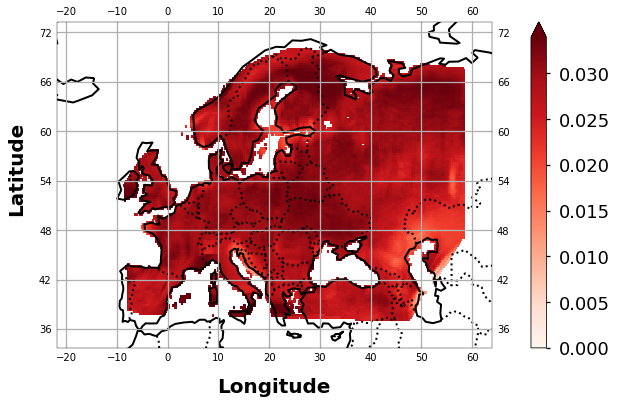

In [31]:
figures_path = '/home/emmanuel/projects/2019_sakame/reports/figures/sampling/'
variable='gross_primary_productivity'
cmap = "Reds"
cbar_kwargs = {
    'label':'', 
    "fraction": 0.035, 
    "pad": 0.08, 
    "cmap": cmap,
#     "labelsize": 20
#     "ticks": [0, 1]
}

with xr.open_dataset(data_xr_path + f"sampling_{variable}.nc") as xr_data:
    # select data subset
    for iwindow in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
        print(f'WINDOW: {iwindow}x{iwindow}')
        subset = xr_data.sensitivity.sel(window=iwindow).mean(dim='time', skipna=True).where(xr_data.mask == 1)
#         subset = subset.drop(['mask', 'window'])
#         print(subset)
#         print('Before', subset.min(), subset.max())
        subset = subset.where(subset > 0.0, np.nan)
#         print('After', subset.min(), subset.max())

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

        pts = subset.plot.pcolormesh(
            ax=ax, transform=ccrs.PlateCarree(),
            robust=True, 
            cmap=cmap, vmin=0, vmax=None,
            add_colorbar=False
#             cbar_kwargs=cbar_kwargs,
#             norm = matplotlib.colors.LogNorm()
        )
    #     cbar = fig.colorbar(p)
#         ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
        cb = plt.colorbar(pts, orientation="vertical", pad=0.07, extend='max')
#         cb.set_label(label='Temperature ($^{\circ}$C)', size='large', weight='bold')
        cb.ax.tick_params(labelsize=18)
        ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
        ax.set_title('')
        ax.coastlines(linewidth=2)
        ax.gridlines(draw_labels=True)
        ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=20,
                weight='bold',
                transform=ax.transAxes)
        ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
                rotation='horizontal', rotation_mode='anchor', fontsize=20,
                weight='bold',
                transform=ax.transAxes)
        plt.tight_layout()
        save_plt_name = f'gpp_sens_{iwindow}'
        plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
        plt.show()

In [32]:
variable = 'gross_primary_productivity'
gpp_df = pd.read_csv(data_xr_path + f'sampling_{variable}.csv')

df = gpp_df.groupby(['window'], as_index=False).mean()


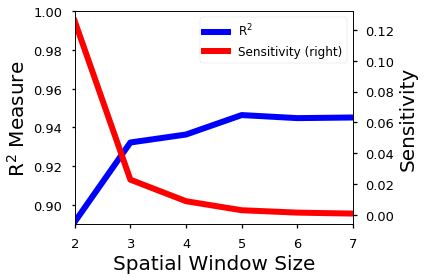

In [33]:
# Plot
fig, ax = plt.subplots()

df.plot(
    ax=ax,
    x='window',
    y=['r2'],
    label=[r'R$^2$'],
    linewidth=6,
    color='blue'
)

df.plot(
    ax=ax,
    x='window',
    y=['sens'],
    secondary_y=True,
    label=['Sensitivity'],
    linewidth=6,
    color='red'
)



ax.set_xlabel('Spatial Window Size', fontsize=20)
ax.set_ylabel(r'R$^2$ Measure', fontsize=20)
ax.right_ax.set_ylabel('Sensitivity', fontsize=20)
# ax.legend([r"R$^2$", "sensitivity"], loc='center right', fontsize=20)
ax.set_xlim([2, 7])
ax.set_ylim([0.89, 1.0])
plt.rc('legend',fontsize=12)
# plt.rc('xtick.major',size=20)
# plt.rc('xtick.minor',size=.1)
plt.tight_layout()
plt.savefig(figures_path + 'gpp_summary' + '.png', transparent=True)
plt.show()

## Land Surface Temperature

In [36]:
import matplotlib.colors as mcol

WINDOW: 2x2


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


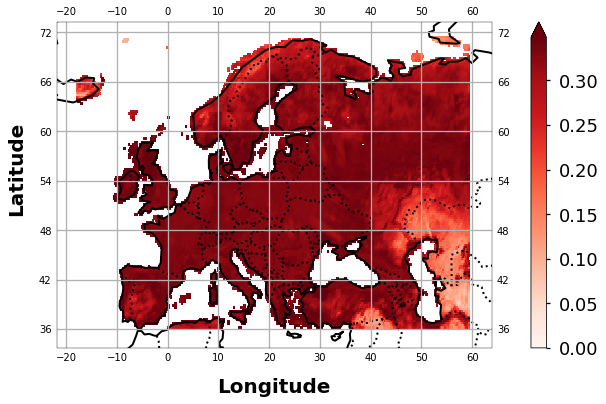

WINDOW: 3x3


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


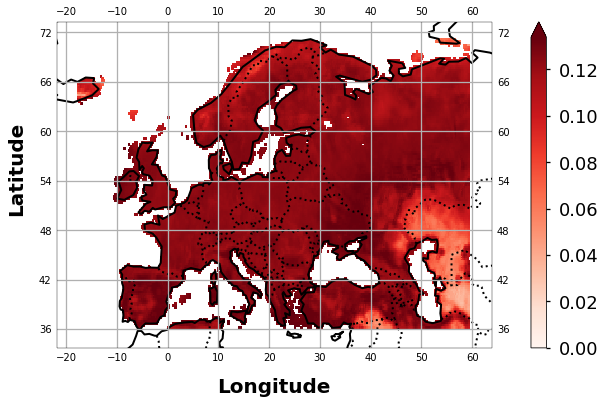

WINDOW: 4x4


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


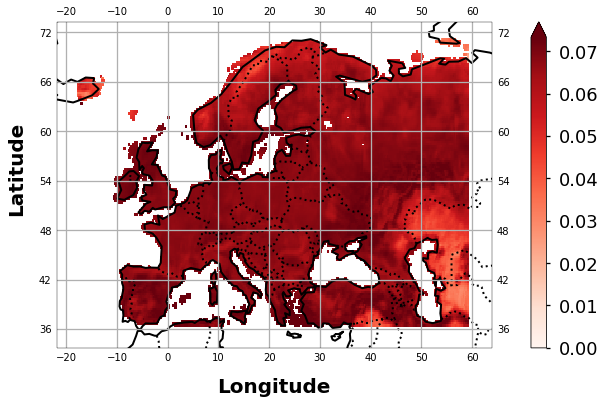

WINDOW: 5x5


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


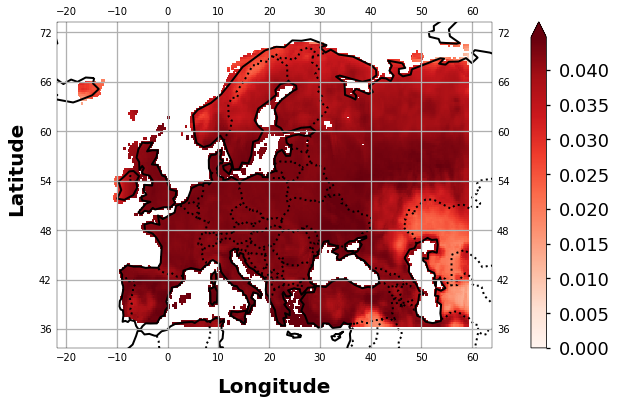

WINDOW: 6x6


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


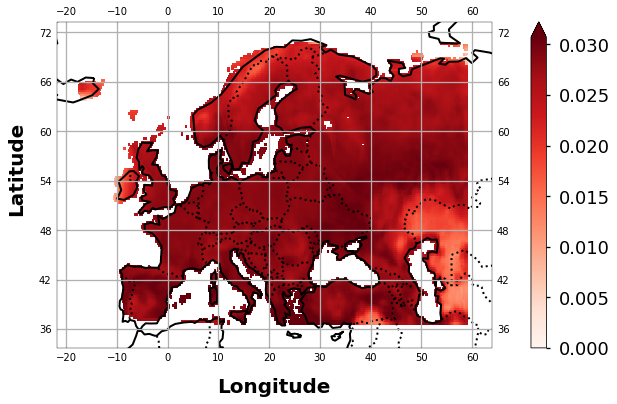

WINDOW: 7x7


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


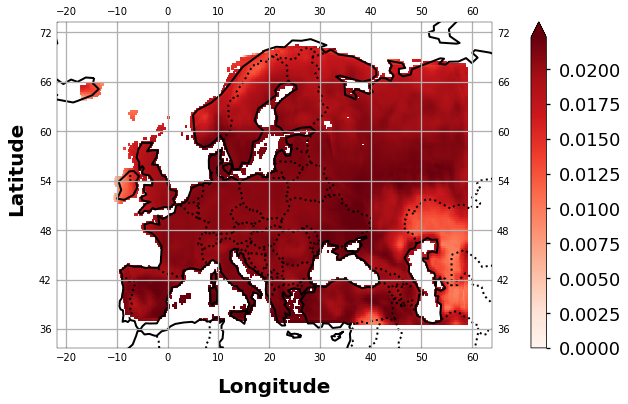

In [29]:
figures_path = '/home/emmanuel/projects/2019_sakame/reports/figures/sampling/'
variable = 'land_surface_temperature'
cbar_kwargs = {
    'label':'', 
    "fraction": 0.035, 
    "pad": 0.08, 
    "cmap": "Reds",
#     "labelsize": 20
#     "ticks": [0, 1]
}

with xr.open_dataset(data_xr_path + f"sampling_{variable}.nc") as xr_data:
    # select data subset
    for iwindow in [2, 3, 4, 5, 6, 7, ]:
        print(f'WINDOW: {iwindow}x{iwindow}')
        subset = xr_data.sensitivity.sel(window=iwindow).mean(dim='time', skipna=True).where(xr_data.mask == 1)
#         subset = subset.drop(['mask', 'window'])
#         print(subset)
#         print('Before', subset.min(), subset.max())
        subset = subset.where(subset > 0.0, np.nan)
#         print('After', subset.min(), subset.max())

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

        pts = subset.plot.pcolormesh(
            ax=ax, transform=ccrs.PlateCarree(),
            robust=True, 
            cmap="Reds", vmin=0, vmax=None,
            add_colorbar=False
#             cbar_kwargs=cbar_kwargs,
#             norm = matplotlib.colors.LogNorm()
        )
    #     cbar = fig.colorbar(p)
#         ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
        cb = plt.colorbar(pts, orientation="vertical", pad=0.07, extend='max')
#         cb.set_label(label='Temperature ($^{\circ}$C)', size='large', weight='bold')
        cb.ax.tick_params(labelsize=18)
        ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
        ax.set_title('')
        ax.coastlines(linewidth=2)
        ax.gridlines(draw_labels=True)
        ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=20,
                weight='bold',
                transform=ax.transAxes)
        ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
                rotation='horizontal', rotation_mode='anchor', fontsize=20,
                weight='bold',
                transform=ax.transAxes)
        plt.tight_layout()
        save_plt_name = f'lst_sens_{iwindow}'
        plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
        plt.show()

In [20]:

variable = 'land_surface_temperature'
lst_df = pd.read_csv(data_xr_path + f'sampling_{variable}.csv')

# lst_df

In [21]:
df = lst_df.groupby(['window'], as_index=False).mean()
df

,window,Unnamed: 0,mae,mse,r2,rmse,sens
0,2.0,5,1.591224,5.850339,0.953453,2.401914,0.102762
1,3.0,16,1.231922,3.590764,0.972382,1.877778,0.014867
2,4.0,27,1.353659,4.278468,0.967495,2.044161,0.004345
3,5.0,38,1.490595,5.051169,0.960015,2.225505,0.001630
4,6.0,49,1.529701,5.305228,0.957100,2.282473,0.000766
5,7.0,60,1.598900,5.658781,0.954454,2.358698,0.000407


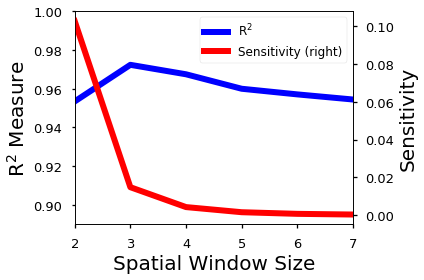

In [26]:
# Plot
fig, ax = plt.subplots()

df.plot(
    ax=ax,
    x='window',
    y=['r2'],
    label=[r'R$^2$'],
    linewidth=6,
    color='blue'
)

df.plot(
    ax=ax,
    x='window',
    y=['sens'],
    secondary_y=True,
    label=['Sensitivity'],
    linewidth=6,
    color='red'
)


ax.set_xlabel('Spatial Window Size', fontsize=20)
ax.set_ylabel(r'R$^2$ Measure', fontsize=20)
ax.right_ax.set_ylabel('Sensitivity', fontsize=20)
plt.rc('legend',fontsize=12)
ax.set_xlim([2, 7])
ax.set_ylim([0.89, 1.0])
plt.tight_layout()
plt.savefig(figures_path + 'lst_summary.png', transparent=True)
plt.show()

## Air Temperature 2m

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


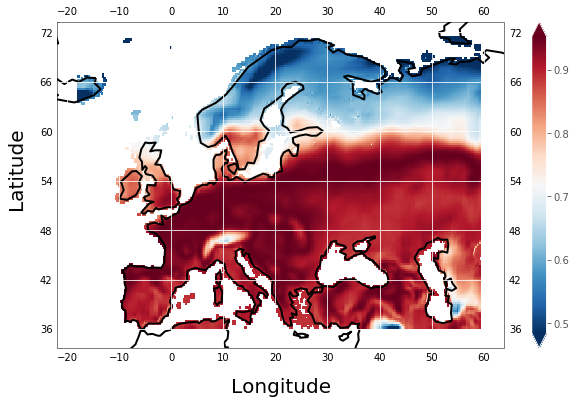

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


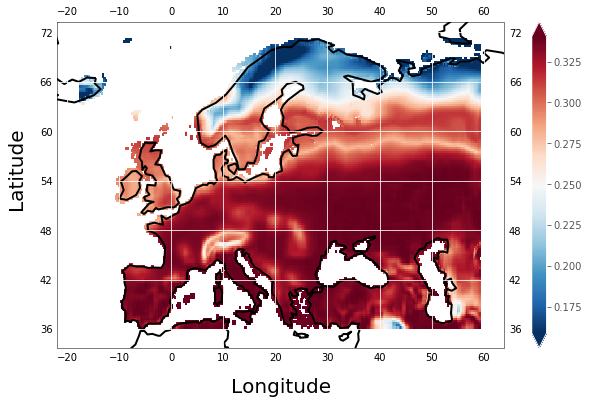

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


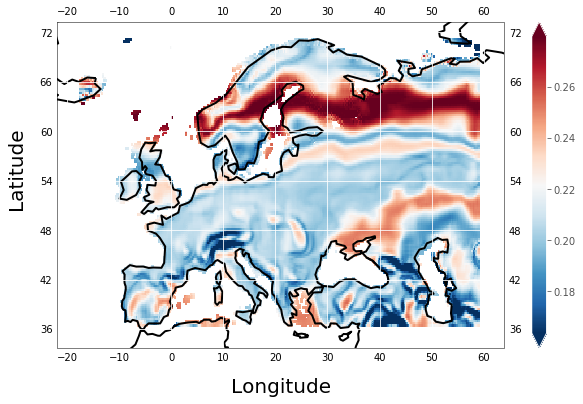

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


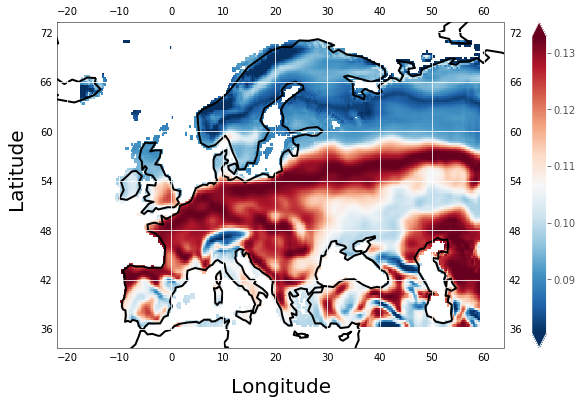

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


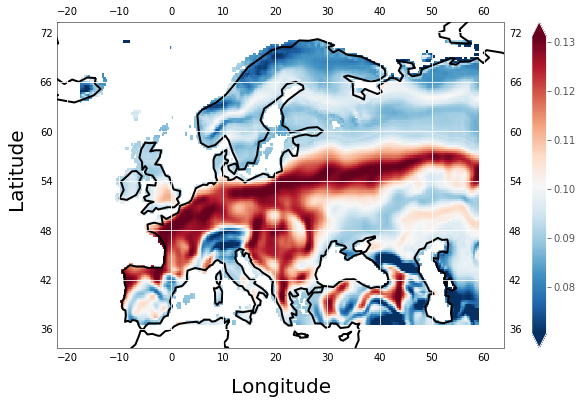

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


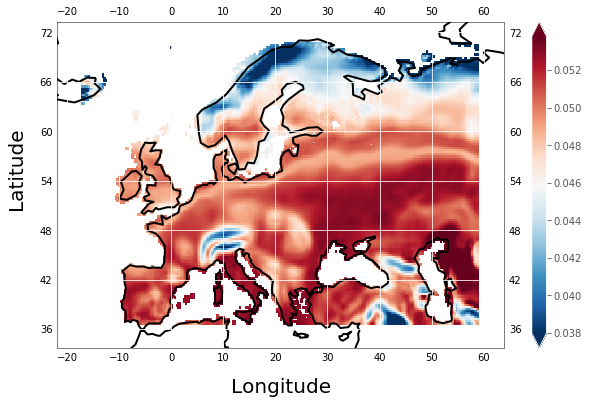

In [88]:
figures_path = '/home/emmanuel/projects/2019_sakame/reports/figures/sampling/'
variable = 'air_temperature_2m'
with xr.open_dataset(data_xr_path + f"sampling_{variable}.nc") as xr_data:
    # select data subset
    for iwindow in [2, 3, 4, 5, 6, 7]:
#         subset = xr_data.sensitivity.sel(window=iwindow).mean(dim='time').where(xr_data.mask == 1)
        subset = xr_data.sensitivity.sel(window=iwindow).isel(time=0).where(xr_data.mask == 1)


        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

        p = subset.plot.pcolormesh(
            ax=ax, transform=ccrs.PlateCarree(),
            robust=True, 
            cmap='RdBu_r', 
    #             cbar_kwargs={'label': subset.gross_primary_productivity.units, 
    #                          'format': '%.1f'}
        )
    #     cbar = fig.colorbar(p)
        ax.set_title('')
        ax.coastlines(linewidth=2)
        ax.gridlines(draw_labels=True)
        ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=20,
                transform=ax.transAxes)
        ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
                rotation='horizontal', rotation_mode='anchor', fontsize=20,
                transform=ax.transAxes)
        plt.tight_layout()
        save_plt_name = f'air_sens_{iwindow}'
        plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
        plt.show()

In [89]:

variable = 'air_temperature_2m'
air_df = pd.read_csv(data_xr_path + f'sampling_{variable}.csv')

# lst_df

In [90]:
df = air_df.groupby(['window'], as_index=False).mean()
df

,window,Unnamed: 0,mae,mse,r2,rmse,sens
0,2.0,5,0.057557,0.025356,0.999425,0.155531,0.272424
1,3.0,16,0.030497,0.012016,0.999722,0.105179,0.038111
2,4.0,27,0.047011,0.059441,0.998596,0.210586,0.014397
3,5.0,38,0.046094,0.028961,0.999311,0.159290,0.004499
4,6.0,49,0.054065,0.049218,0.998829,0.212580,0.002770
5,7.0,60,0.045946,0.019090,0.999532,0.135189,0.001032
6,8.0,71,0.049856,0.017764,0.999559,0.131987,0.000671
7,9.0,82,0.055576,0.021474,0.999459,0.145074,0.000412
8,10.0,93,0.059463,0.038072,0.999030,0.181960,0.000275


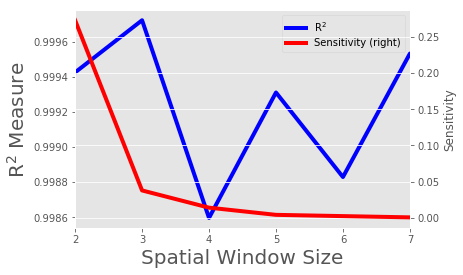

In [91]:
# Plot
fig, ax = plt.subplots()

df.plot(
    ax=ax,
    x='window',
    y=['r2'],
    label=[r'R$^2$'],
    linewidth=4,
    color='blue'
)

df.plot(
    ax=ax,
    x='window',
    y=['sens'],
    secondary_y=True,
    label=['Sensitivity'],
    linewidth=4,
    color='red'
)


ax.set_xlabel('Spatial Window Size', fontsize=20)
ax.set_ylabel(r'R$^2$ Measure', fontsize=20)
ax.right_ax.set_ylabel('Sensitivity')
ax.set_xlim([2, 7])
plt.savefig(figures_path + 'lst_summary.png', transparent=True)
plt.show()